In [1]:
import requests
import pandas as pd
import numpy as np

import imageio
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (15, 10)})

# [Get Data](https://www.youtube.com/watch?v=oJN6jUCy208)

 - Download directly from ourworldindata.org
 - Then parse json into a df

In [2]:
%%time
data_json = requests.get(
    "https://covid.ourworldindata.org/data/owid-covid-data.json"
).json()

CPU times: user 808 ms, sys: 80.6 ms, total: 889 ms
Wall time: 1.04 s


In [3]:
%%time
all_df = []
for country in data_json:
    df = pd.DataFrame(data_json[country]["data"])
    for key in data_json[country].keys():
        if key != "data":
            df[key] = data_json[country][key]
    all_df.append(df)
all_df = pd.concat(all_df, ignore_index=True)
all_df["date"] = pd.to_datetime(all_df["date"])

CPU times: user 3.44 s, sys: 23.7 ms, total: 3.46 s
Wall time: 3.46 s


In [4]:
all_df

,date,total_cases,new_cases,total_cases_per_million,new_cases_per_million,stringency_index,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,...,female_smokers,male_smokers,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million
0,2020-02-24,1.0,1.0,0.026,0.026,8.33,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25,1.0,0.0,0.026,0.000,8.33,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-26,1.0,0.0,0.026,0.000,8.33,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-27,1.0,0.0,0.026,0.000,8.33,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-28,1.0,0.0,0.026,0.000,8.33,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80091,2021-04-03,36911.0,8.0,2483.427,0.538,57.41,13.286,0.714,0.894,0.048,...,1.6,30.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80092,2021-04-04,36923.0,12.0,2484.235,0.807,57.41,14.429,0.714,0.971,0.048,...,1.6,30.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80093,2021-04-05,36934.0,11.0,2484.975,0.740,NaN,13.571,0.714,0.913,0.048,...,1.6,30.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80094,2021-04-06,36966.0,32.0,2487.128,2.153,NaN,18.143,1.571,1.221,0.106,...,1.6,30.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Columns I might want to look at...

In [5]:
[column for column in all_df.columns if "vaccin" in column]

['total_vaccinations',
 'people_vaccinated',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_hundred',
 'new_vaccinations_smoothed',
 'new_vaccinations_smoothed_per_million',
 'new_vaccinations',
 'people_fully_vaccinated',
 'people_fully_vaccinated_per_hundred']

In [6]:
[column for column in all_df.columns if "million" in column]

['total_cases_per_million',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'new_deaths_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_vaccinations_smoothed_per_million',
 'icu_patients_per_million',
 'hosp_patients_per_million',
 'weekly_hosp_admissions_per_million',
 'weekly_icu_admissions_per_million']

# make a plotting function

In [7]:
vax_rate = all_df.groupby("location")["people_fully_vaccinated_per_hundred"].max()

In [8]:
def plot_comparison(
    x="people_fully_vaccinated_per_hundred",
    y="icu_patients_per_million",
    vax_rate_min=10,
    date=all_df["date"].max(),
):
    data = all_df.dropna(subset=[x, y])
    data = data[data["date"] <= date]
    hue_order = [
        country
        for country in vax_rate[vax_rate > vax_rate_min].index
        if country in data["location"].unique()
    ]

    f = sns.lineplot(x=x, y=y, data=data, hue="location", hue_order=hue_order,)
    _ = f.set_title(
        f"Date: {np.datetime_as_string(np.datetime64(date), unit='D')} -- Countries that have achieved >{vax_rate_min}% fully vaccinated rate"
    )
    _ = f.set_xlabel(x.replace("_", " "))
    _ = f.set_ylabel(y.replace("_", " "))
    _ = f.set_xlim(left=0)
    _ = f.set_ylim(bottom=0)

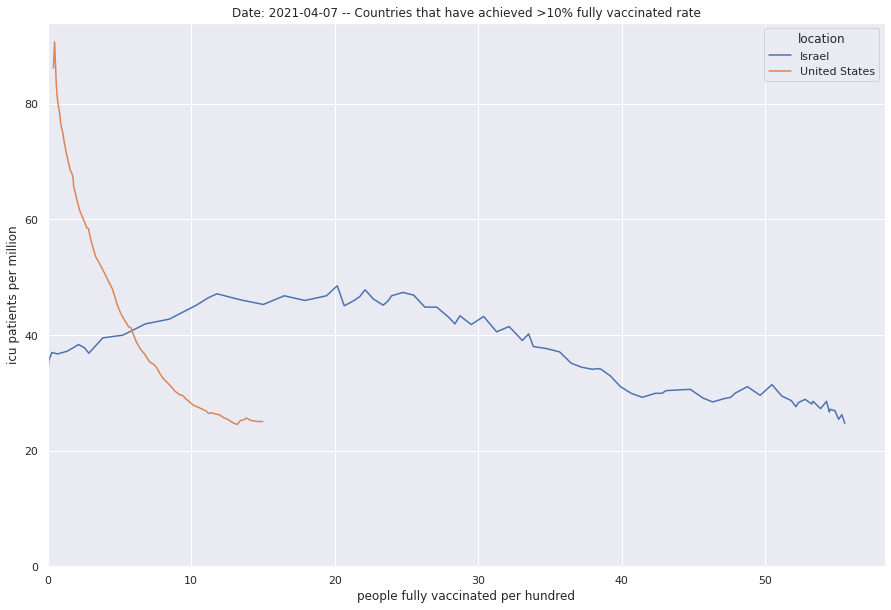

In [9]:
plot_comparison(
    x="people_fully_vaccinated_per_hundred",
    y="icu_patients_per_million",
    vax_rate_min=10,
)

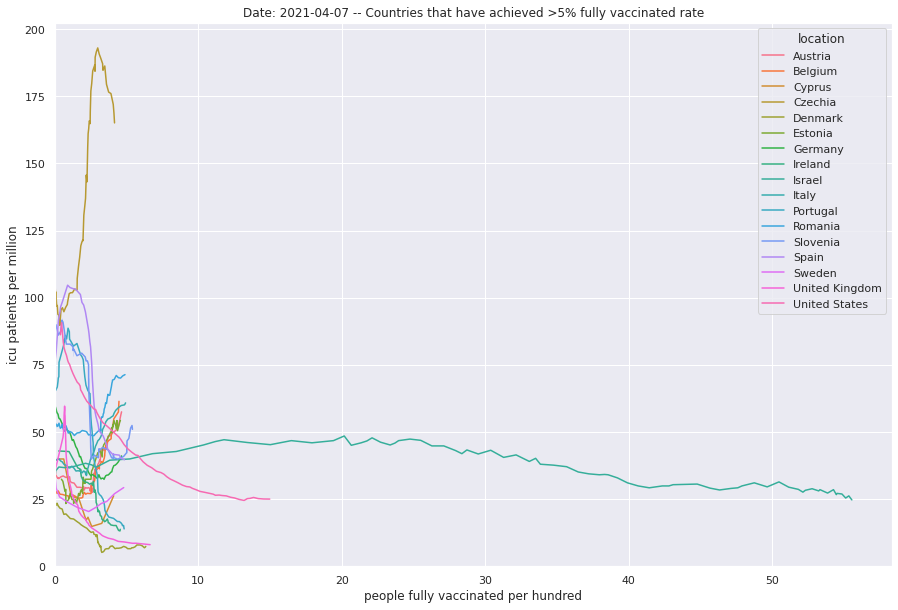

In [10]:
plot_comparison(
    x="people_fully_vaccinated_per_hundred",
    y="icu_patients_per_million",
    vax_rate_min=5,
)

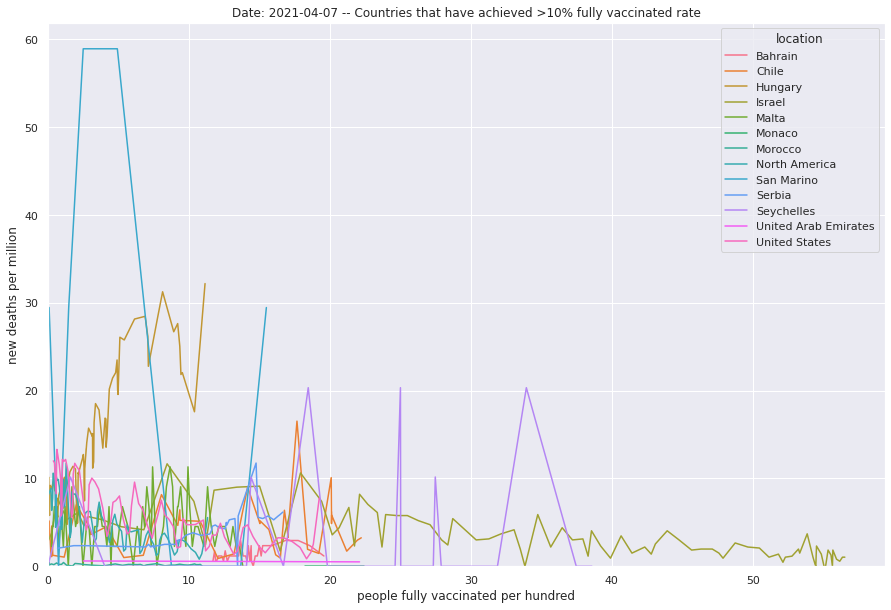

In [11]:
plot_comparison(
    x="people_fully_vaccinated_per_hundred",
    y="new_deaths_per_million",
    vax_rate_min=10,
)

In [12]:
def gif_comparison(
    x="people_fully_vaccinated_per_hundred",
    y="icu_patients_per_million",
    vax_rate_min=10,
):
    dates = all_df.dropna(subset=[x, y])["date"].unique()
    dates.sort()

    filenames = []
    for date in tqdm(dates):
        plot_comparison(
            x=x, y=y, vax_rate_min=vax_rate_min, date=date,
        )
        filename = np.datetime_as_string(date, unit="D") + ".png"
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()

    # build gif
    with imageio.get_writer(
        f"{x}_vs_{y}_min_{vax_rate_min}.gif", mode="I", loop=1
    ) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [13]:
%%time
gif_comparison(vax_rate_min=10)

100%|██████████| 96/96 [00:31<00:00,  3.03it/s]


CPU times: user 38.5 s, sys: 586 ms, total: 39.1 s
Wall time: 39.1 s


![SegmentLocal](people_fully_vaccinated_per_hundred_vs_icu_patients_per_million_min_10.gif "segment")

In [14]:
%%time
gif_comparison(vax_rate_min=5)

100%|██████████| 96/96 [02:19<00:00,  1.45s/it]


CPU times: user 2min 26s, sys: 1.58 s, total: 2min 28s
Wall time: 2min 27s


![SegmentLocal](people_fully_vaccinated_per_hundred_vs_icu_patients_per_million_min_5.gif "segment")